In [1]:
## Standard Imports ##
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

import numpy as np
import scipy as sp

import time as timeit
import datetime
import sys,os

# Compare Results Between Bayesian Approximation Techniques
This code was developed to make a direct comparison between the results of each inference algorithm adopted in this example. The results are examined from a variety of perspectives, including:

1. The relationship between the selection of the prior on the parameters and the accuracy of the mode of the posterior on the parameters. ($J_0$)
2. The model calibration accuracy over the 50 identification trials. ($J_1$)
3. The response reconstruction accuracy, or the measure of the accuracy with which the system behavior remodeled from the posterior modes of the parameters matches the true states. ($J_2$)
4. The one-step-ahead inference accuracy, or the measure of the accuracy of the predictive step of the filter in anticipating the true response behavior of the system. ($J_3$)
5. The predictive accuracy, or the measure of the accuracy of the posterior predictive model in comparison to the true states of a secondary input excitation. ($J_4$)
6. The rate of instability, which represents the percentage of models for which either the infered or predictive distributions manifest instability. ($J_5$)
7. The computational efficiency, or ratio of the run time associated with each algorithm to that of the algorithm requiring the least computational time. ($J_6$)

__Developed by__: Alana Lund (Purdue University) \
__Last Updated__: 1 Nov. 2021 \
__License__: AGPL-3.0

## Load True Response and Input Data for Inference Case

In [2]:
## Assert File Names
inFile = '../04-Data/Bouc-Wen/inferenceInput'
infData = np.load(inFile + '.npz')

dt = infData['dt']                 # time step [sec]
time = infData['time']             # time history [sec]
inpAcc = infData['inpAcc']         # observations on input acceleration [m/sec^2]
states = infData['statesPNoise']   # states (for post-inference validation) [m,m/sec,m]
respAcc = infData['accPMNoise']    # observations on response acceleration [m/sec^2]
Q = infData['Qfactor']             # process noise contributions, independent std. dev. per state [m,m/sec,m]
R = infData['Rfactor']             # measurement noise contribution [m/sec^2]
m = infData['m']                   # mass [kg]
ics = infData['ics']               # true initial conditions of the system [m, m/sec, m]
parTrue = infData['par']               # true parameters of the system [xi (-), wn (rad/sec), beta [1/m^2], n [-], gamma [1/m^2]] 

### Lay Out Problem Dimensionality ###
nInf = 8                     # Number of inferred variables [-]
nState = states.shape[0]     # Number of states [-]
nPar = nInf - nState         # Number of parameters [-]
samps = len(time)            # Number of system measurements [-]
priors = 50                  # Number of priors on the parameters [-]

## Load Inference Data from all Methods

In [4]:
outFileUKF = '../04-Data/Bouc-Wen/outputUKF'
outFileEKF = '../04-Data/Bouc-Wen/outputEKF'
outFilePF = '../04-Data/Bouc-Wen/outputPF'
outFileVI = '../04-Data/Bouc-Wen/outputVI'

## Load EKF Inference History Data ##
outData = np.load(outFileEKF +'.npz')

muHistEKF = outData['muHist']         # inference history of untransformed state/par means (parPriors.shape[0],nInf, samps)
stdHistEKF = outData['stdHist']       # inference history of state/par standard deviations (parPriors.shape[0],nInf, samps)
meanHistEKF = outData['meanHist']     # inference history of transformed state/par means (parPriors.shape[0],nInf, samps)
modeHistEKF = outData['modeHist']     # inference history of transformed state/par modes (parPriors.shape[0],nInf, samps)
modStatesEKF = outData['modStates']   # states that have been remodeled based on the final modes of the parameters 
runTimeEKF = outData['runTime']       # computational time [sec]

## Load UKF Inference History Data ##
outData = np.load(outFileUKF +'.npz')

muHistUKF = outData['muHist']         # inference history of untransformed state/par means (parPriors.shape[0],nInf, samps)
stdHistUKF = outData['stdHist']       # inference history of state/par standard deviations (parPriors.shape[0],nInf, samps)
meanHistUKF = outData['meanHist']     # inference history of transformed state/par means (parPriors.shape[0],nInf, samps)
modeHistUKF = outData['modeHist']     # inference history of transformed state/par modes (parPriors.shape[0],nInf, samps)
modStatesUKF = outData['modStates']   # states that have been remodeled based on the final modes of the parameters
runTimeUKF = outData['runTime']       # computational time [sec]

## Load PF Inference History Data ##
outData = np.load(outFilePF +'.npz')

muHistPF = outData['muHist']         # inference history of untransformed state/par means (parPriors.shape[0],nInf, samps)
stdHistPF = outData['stdHist']       # inference history of state/par standard deviations (parPriors.shape[0],nInf, samps)
meanHistPF = outData['meanHist']     # inference history of transformed state/par means (parPriors.shape[0],nInf, samps)
modeHistPF = outData['modeHist']     # inference history of transformed state/par modes (parPriors.shape[0],nInf, samps)
modStatesPF = outData['modStates']   # states that have been remodeled based on the final modes of the parameters
runTimePF = outData['runTime']       # computational time [sec]

## Load VI Inference History Data ##
outData = np.load(outFileVI +'.npz')

muHistVI = outData['muHist']         # inference history of untransformed state/par means (parPriors.shape[0],nPar,optIter)
stdHistVI = outData['stdHist']       # inference history of state/par standard deviations (parPriors.shape[0],nPar,optIter)
meanHistVI = outData['meanHist']     # inference history of transformed state/par means (parPriors.shape[0],nPar,optIter)
modeHistVI = outData['modeHist']     # inference history of transformed state/par modes (parPriors.shape[0],nPar,optIter)
modStatesVI = outData['modStates']   # states that have been remodeled based on the final modes of the parameters (parPriors.shape[0],nInf,samps)
muStatesVI = outData['muStates']     # states that have been remodeled based on the final modes of the parameters (parPriors.shape[0],nState, samps)
stdStatesVI = outData['stdStates']   # states that have been remodeled based on the final modes of the parameters (parPriors.shape[0],nState, samps)
runTimeVI = outData['runTime']       # computational time [sec]

## $J_0$: Prior vs. Posterior
In this figure, I examine the relationship between the specification of the prior distribution (distance between the mode of the prior from the true parameter vs. entropy of the prior) and the mode of the posterior distribution (distance between the mode of the posterior from the true parameter)

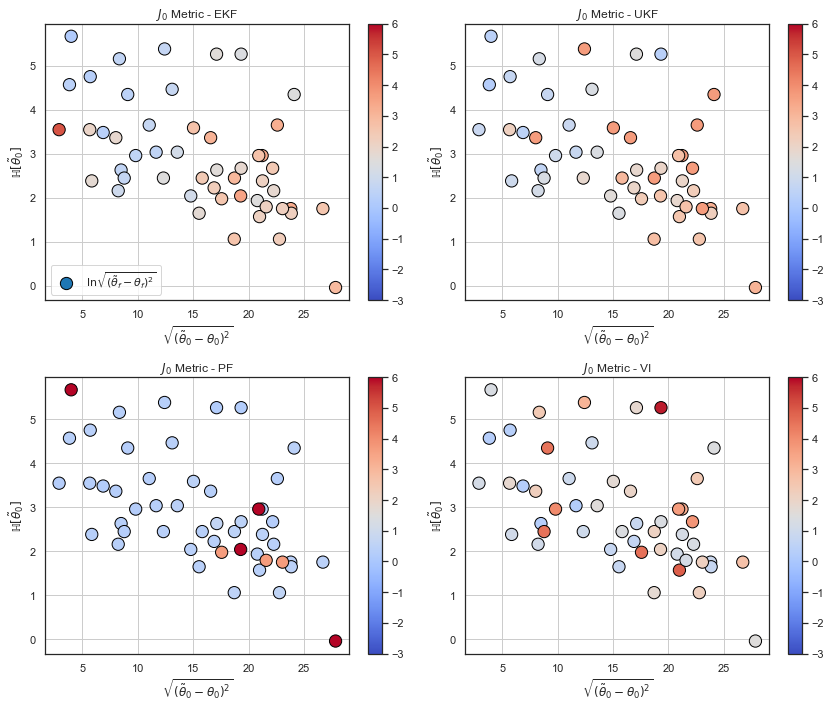

In [4]:
## Load Prior Distribution on the Parameters ##
parPriors = np.loadtxt('../04-Data/parameter_priors.txt')
mu0 = parPriors[:,::2]
std0 = parPriors[:,1::2]

## Calculate Metrics on the Prior -- Constant Among the Algorithms ##
mode0 = np.exp(mu0 - np.square(std0))
    # Mode of each prior distribution
ent0 = mu0.shape[1]/2*np.log(2*np.pi)+ mu0.shape[1]/2 + np.sum(np.log(std0), axis=1)
    # Entropy of the prior distribution
euclid0 = np.sqrt(np.sum(np.square(parTrue-mode0), axis=1))
    # Euclidean distance from the mode of the prior to the true parameters.

## Plot Comparison for EKF ##
euclid_EKF = np.log(np.sqrt(np.sum(np.square(parTrue-modeHistEKF[:,3:,-1]), axis=1)))
    # Euclidean distance from the mode of the posterior to the true parameters. 
euclid_EKF = np.nan_to_num(euclid_EKF,nan=6)
fig, ax = plt.subplots(2,2,figsize = (12,10))
EKF = ax[0,0].scatter(euclid0, ent0, s=150, edgecolor='k', c = euclid_EKF, 
                cmap='coolwarm', vmin = -3, vmax = 6, 
                      label = r'$\ln{\sqrt{(\tilde{\theta}_f - \theta_f)^2}}$')
ax[0,0].grid()
ax[0,0].set_title('$J_0$ Metric - EKF')
ax[0,0].set_xlabel(r'$\sqrt{(\tilde{\theta}_0 - \theta_0)^2}$')
ax[0,0].set_ylabel(r'$\mathrm{\mathbb{H}}[\tilde{\theta}_0]$')
plt.colorbar(EKF, ax=ax[0,0])
ax[0,0].legend()

## Plot Comparison for UKF ##
euclid_UKF = np.log(np.sqrt(np.sum(np.square(parTrue-modeHistUKF[:,3:,-1]), axis=1)))
    # Euclidean distance from the mode of the posterior to the true parameters.
euclid_UKF = np.nan_to_num(euclid_UKF,nan=6)
UKF = ax[0,1].scatter(euclid0, ent0, s=150, edgecolor='k', c = euclid_UKF, 
                cmap='coolwarm', vmin = -3, vmax = 6, 
                      label = r'$\ln{\sqrt{(\tilde{\theta}_f - \theta_f)^2}}$')
ax[0,1].grid()
ax[0,1].set_title('$J_0$ Metric - UKF')
ax[0,1].set_xlabel(r'$\sqrt{(\tilde{\theta}_0 - \theta_0)^2}$')
ax[0,1].set_ylabel(r'$\mathrm{\mathbb{H}}[\tilde{\theta}_0]$')
plt.colorbar(UKF, ax=ax[1,0])
#ax[0,1].legend()

## Plot Comparison for PF ##
euclid_PF = np.log(np.sqrt(np.sum(np.square(parTrue-modeHistPF[:,3:,-1]), axis=1)))
    # Euclidean distance from the mode of the posterior to the true parameters.
euclid_PF = np.nan_to_num(euclid_PF,nan=6)
PF = ax[1,0].scatter(euclid0, ent0, s=150, edgecolor='k', c = euclid_PF, 
                cmap='coolwarm', vmin = -3, vmax = 6, 
                     label = r'$\ln{\sqrt{(\tilde{\theta}_f - \theta_f)^2}}$')
ax[1,0].grid()
ax[1,0].set_title('$J_0$ Metric - PF')
ax[1,0].set_xlabel(r'$\sqrt{(\tilde{\theta}_0 - \theta_0)^2}$')
ax[1,0].set_ylabel(r'$\mathrm{\mathbb{H}}[\tilde{\theta}_0]$')
plt.colorbar(PF, ax=ax[0,1])
#ax[1,0].legend()

## Plot Comparison for VI ##
euclid_VI = np.log(np.sqrt(np.sum(np.square(parTrue-modeHistVI[:,:,-1]), axis=1)))
    # Euclidean distance from the mode of the posterior to the true parameters.
euclid_VI = np.nan_to_num(euclid_VI,nan=6)
VI = ax[1,1].scatter(euclid0, ent0, s=150, edgecolor='k', c = euclid_VI, 
                cmap='coolwarm', vmin = -3, vmax = 6, 
                     label = r'$\ln{\sqrt{(\tilde{\theta}_f - \theta_f)^2}}$')
ax[1,1].grid()
ax[1,1].set_title('$J_0$ Metric - VI')
ax[1,1].set_xlabel(r'$\sqrt{(\tilde{\theta}_0 - \theta_0)^2}$')
ax[1,1].set_ylabel(r'$\mathrm{\mathbb{H}}[\tilde{\theta}_0]$')
plt.colorbar(VI, ax=ax[1,1])
#ax[1,1].legend()

plt.tight_layout()
plt.savefig('../03-Figures/Bouc-Wen/J0.png', dpi=600)

## $J_1$: Model Calibration Accuracy
In this figure, I examine the spread of the candidate models respective to the identified models. The percentage of models for which all parameters are within 20% of the true value are also noted. ## Comparison 2: Robustness to Prior Distribution Variability

0% of the models for the EKF are within 20% of all true parameter values
0% of the models for the UKF are within 20% of all true parameter values
0% of the models for the PF are within 20% of all true parameter values
0% of the models for the VI are within 20% of all true parameter values


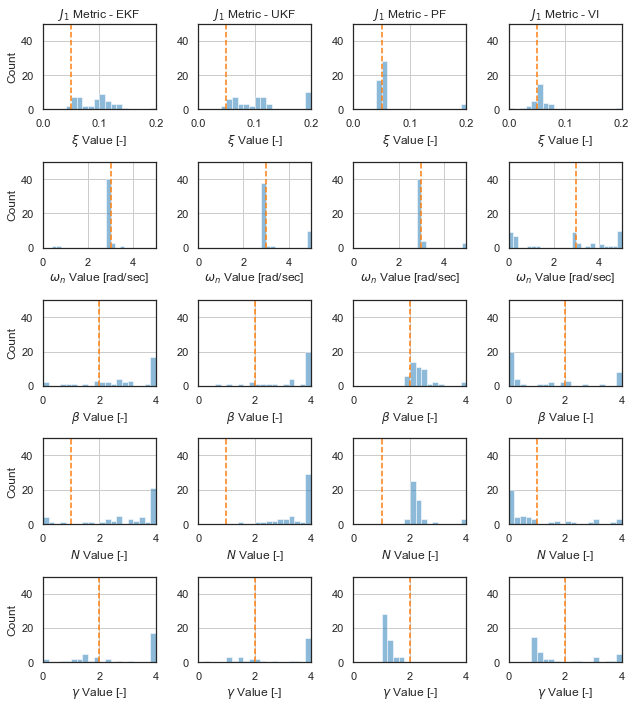

In [5]:
J1 = np.zeros((4))   # Generate storage for the metric
tolerance = 0.8      # Set a tolerance for how close the inferred model
                     # should be to the true model

##### EKF Model #####
modError = np.zeros(priors)
for i in range(priors):
    parErr = np.absolute((modeHistEKF[i,3:,-1] - parTrue)/parTrue)
         # Determine absolute error on the modes of the parameters
    modError[i]= np.sum((parErr <= (1-tolerance))*1)
         # Set indicator for models whose error meets the tolerance criteria 
    
J1[0] = np.sum((modError == nPar)*1)*2
print('%d%s of the models for the EKF are within %d%s of all true parameter values'%(J1[0],"%",np.round((1-tolerance)*100),"%"))

##### UKF Model #####
modError = np.zeros(priors)
for i in range(priors):
    parErr = np.absolute((modeHistUKF[i,3:,-1] - parTrue)/parTrue)
         # Determine absolute error on the modes of the parameters
    modError[i]= np.sum((parErr <= (1-tolerance))*1)
         # Set indicator for models whose error meets the tolerance criteria 
    
J1[1] = np.sum((modError == nPar)*1)*2
print('%d%s of the models for the UKF are within %d%s of all true parameter values'%(J1[1],"%",np.round((1-tolerance)*100),"%"))

##### PF Model #####
modError = np.zeros(priors)
for i in range(priors):
    parErr = np.absolute((modeHistPF[i,3:,-1] - parTrue)/parTrue)
         # Determine absolute error on the modes of the parameters
    modError[i]= np.sum((parErr <= (1-tolerance))*1)
         # Set indicator for models whose error meets the tolerance criteria 
    
J1[2] = np.sum((modError == nPar)*1)*2
print('%d%s of the models for the PF are within %d%s of all true parameter values'%(J1[2],"%",np.round((1-tolerance)*100),"%"))

##### VI Model #####
modError = np.zeros(priors)
for i in range(priors):
    parErr = np.absolute((modeHistVI[i,:,-1] - parTrue)/parTrue)
         # Determine absolute error on the modes of the parameters
    modError[i]= np.sum((parErr <= (1-tolerance))*1)
         # Set indicator for models whose error meets the tolerance criteria 
    
J1[3] = np.sum((modError == nPar)*1)*2
print('%d%s of the models for the VI are within %d%s of all true parameter values'%(J1[3],"%",np.round((1-tolerance)*100),"%"))

np.savetxt('../03-Figures/Bouc-Wen/J1.txt', J1)

### Plot Results ###
# Inferred Models of the Xi Parameter
fig, ax = plt.subplots(5,4,figsize = (9,10))
ax[0,0].plot(np.array([parTrue[0],parTrue[0]]), np.array([0,50]), '--', color = 'C1')
ax[0,0].hist(modeHistEKF[:,3,-1], bins = np.concatenate((np.arange(0,0.2, 0.01), np.array([1]))), label = 'EKF', alpha = 0.5)
ax[0,1].plot(np.array([parTrue[0],parTrue[0]]), np.array([0,50]), '--', color = 'C1')
ax[0,1].hist(modeHistUKF[:,3,-1], bins = np.concatenate((np.arange(0,0.2, 0.01), np.array([1]))), label = 'UKF', alpha = 0.5)
ax[0,2].plot(np.array([parTrue[0],parTrue[0]]), np.array([0,50]), '--', color = 'C1')
ax[0,2].hist(modeHistPF[:,3,-1], bins = np.concatenate((np.arange(0,0.2, 0.01), np.array([1]))), label = 'PF', alpha = 0.5)
ax[0,3].plot(np.array([parTrue[0],parTrue[0]]), np.array([0,50]), '--', color = 'C1')
ax[0,3].hist(modeHistVI[:,0,-1], bins = np.concatenate((np.arange(0,0.2, 0.01), np.array([1]))), label = 'VI', alpha = 0.5)
ax[0,0].set_title(r'$J_1$ Metric - EKF')
ax[0,1].set_title(r'$J_1$ Metric - UKF')
ax[0,2].set_title(r'$J_1$ Metric - PF')
ax[0,3].set_title(r'$J_1$ Metric - VI')
ax[0,0].set_ylabel('Count')
ax[0,0].set_xlabel(r'$\xi$ Value [-]')
ax[0,1].set_xlabel(r'$\xi$ Value [-]')
ax[0,2].set_xlabel(r'$\xi$ Value [-]')
ax[0,3].set_xlabel(r'$\xi$ Value [-]')
ax[0,0].set_xlim((0,0.2))
ax[0,1].set_xlim((0,0.2))
ax[0,2].set_xlim((0,0.2))
ax[0,3].set_xlim((0,0.2))
ax[0,0].set_ylim((0,50))
ax[0,1].set_ylim((0,50))
ax[0,2].set_ylim((0,50))
ax[0,3].set_ylim((0,50))
ax[0,0].grid(1)
ax[0,1].grid(1)
ax[0,2].grid(1)
ax[0,3].grid(1)

# Inferred Models of the Wn Parameter
ax[1,0].plot(np.array([parTrue[1],parTrue[1]]), np.array([0,50]), '--', color = 'C1')
ax[1,0].hist(modeHistEKF[:,4,-1], bins = np.concatenate((np.arange(0,5, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[1,1].plot(np.array([parTrue[1],parTrue[1]]), np.array([0,50]), '--', color = 'C1')
ax[1,1].hist(modeHistUKF[:,4,-1], bins = np.concatenate((np.arange(0,5, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[1,2].plot(np.array([parTrue[1],parTrue[1]]), np.array([0,50]), '--', color = 'C1')
ax[1,2].hist(modeHistPF[:,4,-1], bins = np.concatenate((np.arange(0,5, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[1,3].plot(np.array([parTrue[1],parTrue[1]]), np.array([0,50]), '--', color = 'C1')
ax[1,3].hist(modeHistVI[:,1,-1], bins = np.concatenate((np.arange(0,5, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[1,0].set_ylabel('Count')
ax[1,0].set_xlabel(r'$\omega_n$ Value [rad/sec]')
ax[1,1].set_xlabel(r'$\omega_n$ Value [rad/sec]')
ax[1,2].set_xlabel(r'$\omega_n$ Value [rad/sec]')
ax[1,3].set_xlabel(r'$\omega_n$ Value [rad/sec]')
ax[1,0].set_xlim((0,5))
ax[1,1].set_xlim((0,5))
ax[1,2].set_xlim((0,5))
ax[1,3].set_xlim((0,5))
ax[1,0].set_ylim((0,50))
ax[1,1].set_ylim((0,50))
ax[1,2].set_ylim((0,50))
ax[1,3].set_ylim((0,50))
ax[1,0].grid(1)
ax[1,1].grid(1)
ax[1,2].grid(1)
ax[1,3].grid(1)

## Nonlinear Parameters ##
# Inferred Models of the Beta Parameter
ax[2,0].plot(np.array([parTrue[2],parTrue[2]]), np.array([0,50]), '--', color = 'C1')
ax[2,0].hist(modeHistEKF[:,5,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[2,1].plot(np.array([parTrue[2],parTrue[2]]), np.array([0,50]), '--', color = 'C1')
ax[2,1].hist(modeHistUKF[:,5,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[2,2].plot(np.array([parTrue[2],parTrue[2]]), np.array([0,50]), '--', color = 'C1')
ax[2,2].hist(modeHistPF[:,5,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[2,3].plot(np.array([parTrue[2],parTrue[2]]), np.array([0,50]), '--', color = 'C1')
ax[2,3].hist(modeHistVI[:,2,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[2,0].set_ylabel('Count')
ax[2,0].set_xlabel(r'$\beta$ Value [-]')
ax[2,1].set_xlabel(r'$\beta$ Value [-]')
ax[2,2].set_xlabel(r'$\beta$ Value [-]')
ax[2,3].set_xlabel(r'$\beta$ Value [-]')
ax[2,0].set_xlim((0,4))
ax[2,1].set_xlim((0,4))
ax[2,2].set_xlim((0,4))
ax[2,3].set_xlim((0,4))
ax[2,0].set_ylim((0,50))
ax[2,1].set_ylim((0,50))
ax[2,2].set_ylim((0,50))
ax[2,3].set_ylim((0,50))
ax[2,0].grid(1)
ax[2,1].grid(1)
ax[2,2].grid(1)
ax[2,3].grid(1)

# Inferred Models of the N Parameter
ax[3,0].plot(np.array([parTrue[3],parTrue[3]]), np.array([0,50]), '--', color = 'C1')
ax[3,0].hist(modeHistEKF[:,6,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[3,1].plot(np.array([parTrue[3],parTrue[3]]), np.array([0,50]), '--', color = 'C1')
ax[3,1].hist(modeHistUKF[:,6,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[3,2].plot(np.array([parTrue[3],parTrue[3]]), np.array([0,50]), '--', color = 'C1')
ax[3,2].hist(modeHistPF[:,6,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[3,3].plot(np.array([parTrue[3],parTrue[3]]), np.array([0,50]), '--', color = 'C1')
ax[3,3].hist(modeHistVI[:,3,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[3,0].set_ylabel('Count')
ax[3,0].set_xlabel(r'$N$ Value [-]')
ax[3,1].set_xlabel(r'$N$ Value [-]')
ax[3,2].set_xlabel(r'$N$ Value [-]')
ax[3,3].set_xlabel(r'$N$ Value [-]')
ax[3,0].set_xlim((0,4))
ax[3,1].set_xlim((0,4))
ax[3,2].set_xlim((0,4))
ax[3,3].set_xlim((0,4))
ax[3,0].set_ylim((0,50))
ax[3,1].set_ylim((0,50))
ax[3,2].set_ylim((0,50))
ax[3,3].set_ylim((0,50))
ax[3,0].grid(1)
ax[3,1].grid(1)
ax[3,2].grid(1)
ax[3,3].grid(1)

# Inferred Models of the Gamma Parameter
ax[4,0].plot(np.array([parTrue[4],parTrue[4]]), np.array([0,50]), '--', color = 'C1')
ax[4,0].hist(modeHistEKF[:,7,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[4,1].plot(np.array([parTrue[4],parTrue[4]]), np.array([0,50]), '--', color = 'C1')
ax[4,1].hist(modeHistUKF[:,7,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[4,2].plot(np.array([parTrue[4],parTrue[4]]), np.array([0,50]), '--', color = 'C1')
ax[4,2].hist(modeHistPF[:,7,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[4,3].plot(np.array([parTrue[4],parTrue[4]]), np.array([0,50]), '--', color = 'C1')
ax[4,3].hist(modeHistVI[:,4,-1], bins = np.concatenate((np.arange(0,4, 0.2), np.array([10]))), label = "Vel.", alpha = 0.5)
ax[4,0].set_ylabel('Count')
ax[4,0].set_xlabel(r'$\gamma$ Value [-]')
ax[4,1].set_xlabel(r'$\gamma$ Value [-]')
ax[4,2].set_xlabel(r'$\gamma$ Value [-]')
ax[4,3].set_xlabel(r'$\gamma$ Value [-]')
ax[4,0].set_xlim((0,4))
ax[4,1].set_xlim((0,4))
ax[4,2].set_xlim((0,4))
ax[4,3].set_xlim((0,4))
ax[4,0].set_ylim((0,50))
ax[4,1].set_ylim((0,50))
ax[4,2].set_ylim((0,50))
ax[4,3].set_ylim((0,50))
ax[4,0].grid(1)
ax[4,1].grid(1)
ax[4,2].grid(1)
ax[4,3].grid(1)


plt.tight_layout()
plt.savefig('../03-Figures/Linear/J1.png', dpi=600)

## $J_2$: Response Reconstruction Accuracy
In this figure, I examine the spread of the root-mean-square error between the states developed from the candidate models (modes of the final parameter distribution) and the true system states. 

Lowest State Error for the EKF is: 
	DispHist -- 4, 
	VelHist -- 4, 
	rDispHist -- 4

Lowest State Error for the UKF is: 
	DispHist -- 15, 
	VelHist -- 4, 
	rDispHist -- 4

Lowest State Error for the PF is: 
	DispHist -- 29, 
	VelHist -- 2, 
	rDispHist -- 41

Lowest State Error for the VI is: 
	DispHist -- 15, 
	VelHist -- 15, 
	rDispHist -- 26



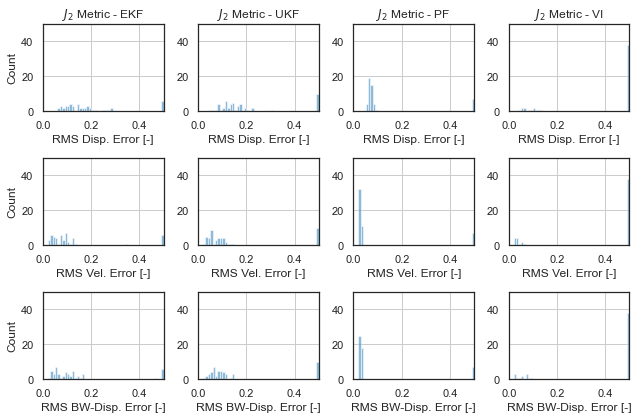

In [6]:
J2_all = np.zeros((4,2*nState))
    # Generate storage for the metric over all inference trials 
J2_stable = np.zeros((4,2*nState)) 
    # Generate storage for the metric, considering only the stable cases


##### EKF Model #####
## Find the Normalized RMS Error on the Remodeled States ##
RMS_EKF = (np.sqrt(np.mean(np.square(states-modStatesEKF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(states), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_EKF))*1, axis=1) == nState)*1
stableRMS_EKF = RMS_EKF[stabilityInd != 0,:]

findNans = np.isnan(RMS_EKF)
RMS_EKF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_EKF, axis = 0)
print('Lowest State Error for the EKF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J2_all[0,::2] = np.mean(RMS_EKF, axis = 0)
J2_all[0,1::2] = np.std(RMS_EKF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J2_stable[0,::2] = np.mean(stableRMS_EKF, axis = 0)
J2_stable[0,1::2] = np.std(stableRMS_EKF, axis = 0)



##### UKF Model #####
## Find the Normalized RMS Error on the Remodeled States ##
RMS_UKF = (np.sqrt(np.mean(np.square(states-modStatesUKF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(states), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_UKF))*1, axis=1) == nState)*1
stableRMS_UKF = RMS_UKF[stabilityInd != 0,:]

findNans = np.isnan(RMS_UKF)
RMS_UKF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_UKF, axis = 0)
print('Lowest State Error for the UKF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J2_all[1,::2] = np.mean(RMS_UKF, axis = 0)
J2_all[1,1::2] = np.std(RMS_UKF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J2_stable[1,::2] = np.mean(stableRMS_UKF, axis = 0)
J2_stable[1,1::2] = np.std(stableRMS_UKF, axis = 0)



##### PF Model #####
## Find the Normalized RMS Error on the Remodeled States ##
RMS_PF = (np.sqrt(np.mean(np.square(states-modStatesPF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(states), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_PF))*1, axis=1) == nState)*1
stableRMS_PF = RMS_PF[stabilityInd != 0,:]

findNans = np.isnan(RMS_PF)
RMS_PF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_PF, axis = 0)
print('Lowest State Error for the PF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J2_all[2,::2] = np.mean(RMS_PF, axis = 0)
J2_all[2,1::2] = np.std(RMS_PF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J2_stable[2,::2] = np.mean(stableRMS_PF, axis = 0)
J2_stable[2,1::2] = np.std(stableRMS_PF, axis = 0)



##### VI Model #####
## Find the Normalized RMS Error on the Remodeled States ##
RMS_VI = (np.sqrt(np.mean(np.square(states-modStatesVI[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(states), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_VI))*1, axis=1) == nState)*1
stableRMS_VI = RMS_VI[stabilityInd != 0,:]

findNans = np.isnan(RMS_VI)
RMS_VI[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_VI, axis = 0)
print('Lowest State Error for the VI is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J2_all[3,::2] = np.mean(RMS_VI, axis = 0)
J2_all[3,1::2] = np.std(RMS_VI, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J2_stable[3,::2] = np.mean(stableRMS_VI, axis = 0)
J2_stable[3,1::2] = np.std(stableRMS_VI, axis = 0)

np.savetxt('../03-Figures/Bouc-Wen/J2_stable.txt', J2_stable)
np.savetxt('../03-Figures/Bouc-Wen/J2_all.txt', J2_all)

### Plot Summative Figure ###
fig, ax = plt.subplots(3,4,figsize = (9,6))
ax[0,0].hist(RMS_EKF[:,0], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = 'EKF', alpha = 0.5)
ax[0,1].hist(RMS_UKF[:,0], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = 'UKF', alpha = 0.5)
ax[0,2].hist(RMS_PF[:,0], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = 'PF', alpha = 0.5)
ax[0,3].hist(RMS_VI[:,0], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = 'VI', alpha = 0.5)
ax[0,0].set_title(r'$J_2$ Metric - EKF')
ax[0,1].set_title(r'$J_2$ Metric - UKF')
ax[0,2].set_title(r'$J_2$ Metric - PF')
ax[0,3].set_title(r'$J_2$ Metric - VI')
ax[0,0].set_ylabel('Count')
ax[0,0].set_xlabel(r'RMS Disp. Error [-]')
ax[0,1].set_xlabel(r'RMS Disp. Error [-]')
ax[0,2].set_xlabel(r'RMS Disp. Error [-]')
ax[0,3].set_xlabel(r'RMS Disp. Error [-]')
ax[0,0].set_xlim((0,0.5))
ax[0,1].set_xlim((0,0.5))
ax[0,2].set_xlim((0,0.5))
ax[0,3].set_xlim((0,0.5))
ax[0,0].set_ylim((0,50))
ax[0,1].set_ylim((0,50))
ax[0,2].set_ylim((0,50))
ax[0,3].set_ylim((0,50))
ax[0,0].grid(1)
ax[0,1].grid(1)
ax[0,2].grid(1)
ax[0,3].grid(1)

ax[1,0].hist(RMS_EKF[:,1], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[1,1].hist(RMS_UKF[:,1], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[1,2].hist(RMS_PF[:,1], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[1,3].hist(RMS_VI[:,1], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[1,0].set_ylabel('Count')
ax[1,0].set_xlabel(r'RMS Vel. Error [-]')
ax[1,1].set_xlabel(r'RMS Vel. Error [-]')
ax[1,2].set_xlabel(r'RMS Vel. Error [-]')
ax[1,3].set_xlabel(r'RMS Vel. Error [-]')
ax[1,0].set_xlim((0,0.5))
ax[1,1].set_xlim((0,0.5))
ax[1,2].set_xlim((0,0.5))
ax[1,3].set_xlim((0,0.5))
ax[1,0].set_ylim((0,50))
ax[1,1].set_ylim((0,50))
ax[1,2].set_ylim((0,50))
ax[1,3].set_ylim((0,50))
ax[1,0].grid(1)
ax[1,1].grid(1)
ax[1,2].grid(1)
ax[1,3].grid(1)

ax[2,0].hist(RMS_EKF[:,2], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[2,1].hist(RMS_UKF[:,2], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[2,2].hist(RMS_PF[:,2], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[2,3].hist(RMS_VI[:,2], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[2,0].set_ylabel('Count')
ax[2,0].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,1].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,2].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,3].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,0].set_xlim((0,0.5))
ax[2,1].set_xlim((0,0.5))
ax[2,2].set_xlim((0,0.5))
ax[2,3].set_xlim((0,0.5))
ax[2,0].set_ylim((0,50))
ax[2,1].set_ylim((0,50))
ax[2,2].set_ylim((0,50))
ax[2,3].set_ylim((0,50))
ax[2,0].grid(1)
ax[2,1].grid(1)
ax[2,2].grid(1)
ax[2,3].grid(1)

plt.tight_layout()
plt.savefig('../03-Figures/Bouc-Wen/J1.png', dpi=600)

## $J_3$: One-Step-Ahead Inference Accuracy
In this figure, I examine the spread of the root-mean-square error between the states developed through "one-step-ahead prediction" and the true system states. The development of the one-step-ahead prediction is meant to simulate the action of a control algorithm, which would use the marginal posterior from the current time step to project the states forward to the next time step, and then develop the appropriate control force based on those predicted states. 

In [7]:
def fx(x, dt, exc=None):
    """
    State transition model for a SDOF oscillator with a Bouc-Wen switch 
    state, given that alpha = 0, and therefore the Bouc-Wen component is 
    switched off.
      
    x = 1x8 vector of states (disp [m], vel [m/sec], Bouc-Wen disp [m]) 
                and parameters to be inferred (log(xi),log(wn), log(beta), 
                log(n), log(gamma)). 
    dt = sampling rate [sec]
    exc = input excitation at current time step [m/sec^2]
    """
    if exc is None:
        exc = np.zeros(x[1].shape)
      
    par = np.exp(x[3:]) 
            
    x1dot = x[0] + dt*x[1]
    x2dot = x[1] + dt*(-exc - (2*par[0]*par[1])*x[1] - np.square(par[1])*x[2])
    x3dot = x[2] + dt*(x[1] 
      - par[2]*np.absolute(x[1])*np.power(np.absolute(x[2]), par[3]-1)*x[2] 
      - par[4]*x[1]*np.power(np.absolute(x[2]), par[3]))

    return np.concatenate((np.stack((x1dot, x2dot, x3dot), axis=0)
                           , x[3:]), axis=0)

Lowest One-Step-Ahead Error for the EKF is: 
	DispHist -- 41, 
	VelHist -- 18, 
	rDispHist -- 37



D:\Programs\Anaconda\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in power
D:\Programs\Anaconda\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Lowest One-Step-Ahead Error for the UKF is: 
	DispHist -- 15, 
	VelHist -- 44, 
	rDispHist -- 26

Lowest One-Step-Ahead Error for the PF is: 
	DispHist -- 37, 
	VelHist -- 15, 
	rDispHist -- 4

Lowest One-Step-Ahead Error for the VI is: 
	DispHist -- 1000, 
	VelHist -- 1000, 
	rDispHist -- 1000



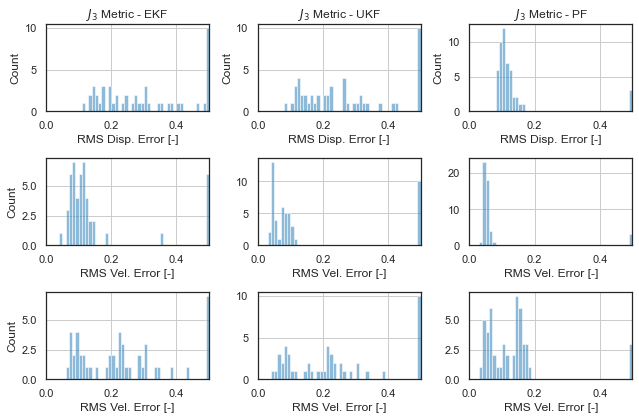

In [8]:
J3_all = np.zeros((4,2*nState))
    # Generate storage for the metric over all inference trials 
J3_stable = np.zeros((4,2*nState)) 
    # Generate storage for the metric, considering only the stable cases

##### EKF Model #####
## Develope the one-step-ahead predictive response history ##
controlStatesEKF = np.zeros((priors,nInf, samps))
for j in range(priors):
    controlStatesEKF[j,:,0] = muHistEKF[j,:,0]
    for i in range(1,samps):
        controlStatesEKF[j,:,i] = fx(muHistEKF[j,:,i-1], dt, exc=inpAcc[i-1])   

## Find the Normalized RMS Error on the States ##
RMS_EKF = (np.sqrt(np.mean(np.square(states-controlStatesEKF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(states), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_EKF))*1, axis=1) == nState)*1
stableRMS_EKF = RMS_EKF[stabilityInd != 0,:]

findNans = np.isnan(RMS_EKF)
RMS_EKF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_EKF, axis = 0)
print('Lowest One-Step-Ahead Error for the EKF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J3_all[0,::2] = np.mean(RMS_EKF, axis = 0)
J3_all[0,1::2] = np.std(RMS_EKF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J3_stable[0,::2] = np.mean(stableRMS_EKF, axis = 0)
J3_stable[0,1::2] = np.std(stableRMS_EKF, axis = 0)        
   
    
    
##### UKF Model #####
## Develope the one-step-ahead predictive response history ##
controlStatesUKF = np.zeros((priors,nInf, samps))
for j in range(priors):
    controlStatesUKF[j,:,0] = muHistUKF[j,:,0]
    for i in range(1,samps):
        controlStatesUKF[j,:,i] = fx(muHistUKF[j,:,i-1], dt, exc=inpAcc[i-1])  

## Find the Normalized RMS Error on the States ##
RMS_UKF = (np.sqrt(np.mean(np.square(states-controlStatesUKF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(states), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_UKF))*1, axis=1) == nState)*1
stableRMS_UKF = RMS_UKF[stabilityInd != 0,:]

findNans = np.isnan(RMS_UKF)
RMS_UKF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_UKF, axis = 0)
print('Lowest One-Step-Ahead Error for the UKF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J3_all[1,::2] = np.mean(RMS_UKF, axis = 0)
J3_all[1,1::2] = np.std(RMS_UKF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J3_stable[1,::2] = np.mean(stableRMS_UKF, axis = 0)
J3_stable[1,1::2] = np.std(stableRMS_UKF, axis = 0)



##### PF Model #####
## Develope the one-step-ahead predictive response history ##
controlStatesPF = np.zeros((priors,nInf, samps))
for j in range(priors):
    controlStatesPF[j,:,0] = muHistPF[j,:,0]
    for i in range(1,samps):
        controlStatesPF[j,:,i] = fx(muHistPF[j,:,i-1], dt, exc=inpAcc[i-1])  
        
## Find the Normalized RMS Error on the States ##
RMS_PF = (np.sqrt(np.mean(np.square(states-controlStatesPF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(states), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_PF))*1, axis=1) == nState)*1
stableRMS_PF = RMS_PF[stabilityInd != 0,:]

findNans = np.isnan(RMS_PF)
RMS_PF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_PF, axis = 0)
print('Lowest One-Step-Ahead Error for the PF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J3_all[2,::2] = np.mean(RMS_PF, axis = 0)
J3_all[2,1::2] = np.std(RMS_PF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J3_stable[2,::2] = np.mean(stableRMS_PF, axis = 0)
J3_stable[2,1::2] = np.std(stableRMS_PF, axis = 0)



##### VI Model #####
# As a batch method, VI does not qualify for the one-step-ahead metric
print('Lowest One-Step-Ahead Error for the VI is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    1000,1000,1000))

J3_stable[3,:] = np.array([1000, 1000, 1000, 1000, 1000, 1000])
J3_all[3,:] = np.array([1000, 1000, 1000, 1000, 1000, 1000])

np.savetxt('../03-Figures/Bouc-Wen/J3_stable.txt', J3_stable)
np.savetxt('../03-Figures/Bouc-Wen/J3_all.txt', J3_all)


### Plot Summative Figure ###
fig, ax = plt.subplots(3,3,figsize = (9,6))
ax[0,0].hist(RMS_EKF[:,0], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = 'EKF', alpha = 0.5)
ax[0,1].hist(RMS_UKF[:,0], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = 'UKF', alpha = 0.5)
ax[0,2].hist(RMS_PF[:,0], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = 'PF', alpha = 0.5)
ax[0,0].set_title(r'$J_3$ Metric - EKF')
ax[0,1].set_title(r'$J_3$ Metric - UKF')
ax[0,2].set_title(r'$J_3$ Metric - PF')
ax[0,0].set_ylabel('Count')
ax[0,1].set_ylabel('Count')
ax[0,2].set_ylabel('Count')
ax[0,0].set_xlabel(r'RMS Disp. Error [-]')
ax[0,1].set_xlabel(r'RMS Disp. Error [-]')
ax[0,2].set_xlabel(r'RMS Disp. Error [-]')
ax[0,0].set_xlim((0,0.5))
ax[0,1].set_xlim((0,0.5))
ax[0,2].set_xlim((0,0.5))
ax[0,0].grid(1)
ax[0,1].grid(1)
ax[0,2].grid(1)

ax[1,0].hist(RMS_EKF[:,1], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[1,1].hist(RMS_UKF[:,1], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[1,2].hist(RMS_PF[:,1], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[1,0].set_xlabel(r'RMS Vel. Error [-]')
ax[1,1].set_xlabel(r'RMS Vel. Error [-]')
ax[1,2].set_xlabel(r'RMS Vel. Error [-]')
ax[1,0].set_ylabel('Count')
ax[1,0].set_xlim((0,0.5))
ax[1,1].set_xlim((0,0.5))
ax[1,2].set_xlim((0,0.5))
ax[1,0].grid(1)
ax[1,1].grid(1)
ax[1,2].grid(1)

ax[2,0].hist(RMS_EKF[:,2], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[2,1].hist(RMS_UKF[:,2], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[2,2].hist(RMS_PF[:,2], bins = np.concatenate((np.arange(0,0.5, 0.01), np.array([5]))), label = "Vel.", alpha = 0.5)
ax[2,0].set_xlabel(r'RMS Vel. Error [-]')
ax[2,1].set_xlabel(r'RMS Vel. Error [-]')
ax[2,2].set_xlabel(r'RMS Vel. Error [-]')
ax[2,0].set_ylabel('Count')
ax[2,0].set_xlim((0,0.5))
ax[2,1].set_xlim((0,0.5))
ax[2,2].set_xlim((0,0.5))
ax[2,0].grid(1)
ax[2,1].grid(1)
ax[2,2].grid(1)

plt.tight_layout()
plt.savefig('../03-Figures/Bouc-Wen/J3.png', dpi=600)

## $J_4$: Predictive Accuracy
In this figure, I examine the spread of the root-mean-square error between the response of the candidate models to a secondary excitation and the true response of the system to that secondary excitation. As the variance of the prediction is particularly important to understanding these results, a normalized metric on the variance for each candidate predictive response is also recorded and plotted. 

In [9]:
## Specify Files and Load Predictive Input ##
predInFile = '../04-Data/Bouc-Wen/predInp_BLWN'
predOutFileUKF = '../04-Data/Bouc-Wen/predOutUKF'
predOutFileEKF = '../04-Data/Bouc-Wen/predOutEKF'
predOutFilePF = '../04-Data/Bouc-Wen/predOutPF'
predOutFileVI = '../04-Data/Bouc-Wen/predOutVI'

infData = np.load(predInFile + '.npz')

dt = infData['dt']                            # time step [sec]
time = infData['time']                        # time history [sec]
predBase = infData['predInp']                 # observations on input acceleration [m/sec^2]
predStatesTrue = infData['predStatesPNoise']  # states (for post-prediction validation) [m,m/sec]
predRespTrue = infData['predAccPMNoise']      # observations on response acceleration [m/sec^2]

## Load Predictive Output for EKF ##
infData = np.load(predOutFileEKF + '.npz')

meanPredEKF = infData['meanPred']                   # mean of predictive distribution for each candidate model
stdPredEKF = infData['stdPred']                     # std dev of predictive distribution for each candidate model
stableMeansEKF = infData['stableMeans']             # mean of predictive distribution for stable candidate models
stableStdsEKF = infData['stableStds']               # std dev of predictive distribution for stable candidate models
meanAllEKF = infData['meanAll']                     # mean taken over all stable candidate model sample predictives
stdAllEKF = infData['stdAll']                       # std dev taken over all stable candidate model sample predictives

## Load Predictive Output for UKF ##
infData = np.load(predOutFileUKF + '.npz')

meanPredUKF = infData['meanPred']                   # mean of predictive distribution for each candidate model
stdPredUKF = infData['stdPred']                     # std dev of predictive distribution for each candidate model
stableMeansUKF = infData['stableMeans']             # mean of predictive distribution for stable candidate models
stableStdsUKF = infData['stableStds']               # std dev of predictive distribution for stable candidate models
meanAllUKF = infData['meanAll']                     # mean taken over all stable candidate model sample predictives
stdAllUKF = infData['stdAll']                       # std dev taken over all stable candidate model sample predictives

## Load Predictive Output for PF ##
infData = np.load(predOutFilePF + '.npz')

meanPredPF = infData['meanPred']                   # mean of predictive distribution for each candidate model
stdPredPF = infData['stdPred']                     # std dev of predictive distribution for each candidate model
stableMeansPF = infData['stableMeans']             # mean of predictive distribution for stable candidate models
stableStdsPF = infData['stableStds']               # std dev of predictive distribution for stable candidate models
meanAllPF = infData['meanAll']                     # mean taken over all stable candidate model sample predictives
stdAllPF = infData['stdAll']                       # std dev taken over all stable candidate model sample predictives

## Load Predictive Output for VI ##
infData = np.load(predOutFileVI + '.npz')

meanPredVI = infData['meanPred']                   # mean of predictive distribution for each candidate model
stdPredVI = infData['stdPred']                     # std dev of predictive distribution for each candidate model
stableMeansVI = infData['stableMeans']             # mean of predictive distribution for stable candidate models
stableStdsVI = infData['stableStds']               # std dev of predictive distribution for stable candidate models
meanAllVI = infData['meanAll']                     # mean taken over all stable candidate model sample predictives
stdAllVI = infData['stdAll']                       # std dev taken over all stable candidate model sample predictives

Lowest Predictive Error for the EKF is: 
	DispHist -- 41, 
	VelHist -- 4, 
	rDispHist -- 4

Lowest Predictive Error for the UKF is: 
	DispHist -- 37, 
	VelHist -- 4, 
	rDispHist -- 4

Lowest Predictive Error for the PF is: 
	DispHist -- 32, 
	VelHist -- 19, 
	rDispHist -- 36

Lowest Predictive Error for the VI is: 
	DispHist -- 26, 
	VelHist -- 6, 
	rDispHist -- 26



D:\Programs\Anaconda\envs\pfTrial\lib\site-packages\ipykernel_launcher.py:149: RuntimeWarning: overflow encountered in square


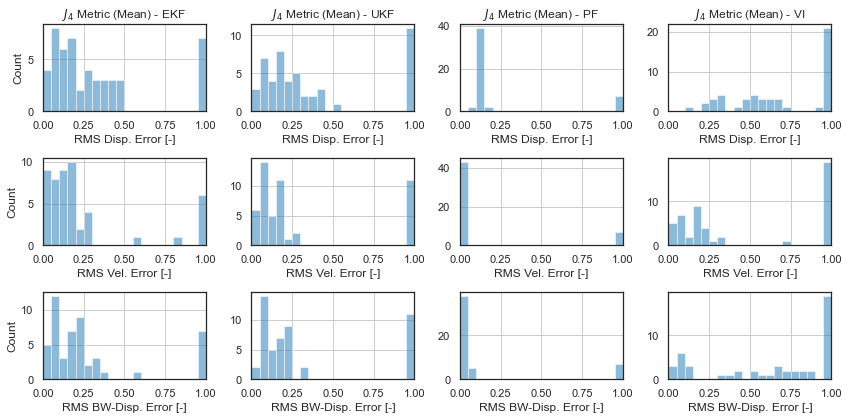

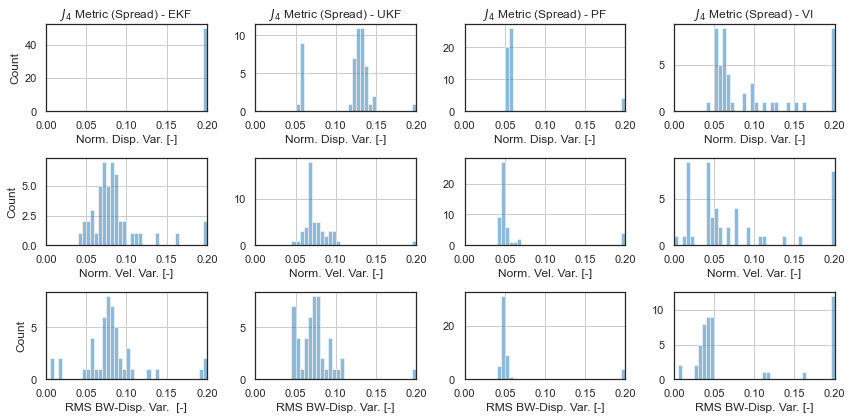

In [11]:
J4means_all = np.zeros((4,2*nState))    # Generate storage for the statistics on the mean of the RMS values 
J4stds_all = np.zeros((4,2*nState))     # Generate storage for the statistics on the standard deviation of the RMS values


J4means_stable = np.zeros((4,2*nState)) # Generate storage for the statistics on the mean of the RMS values (stable)
J4stds_stable = np.zeros((4,2*nState))  # Generate storage for the statistics on the standard deviation of the RMS values (stable)


##### EKF Model #####
## Find the Normalized RMS Error on the Predictive States ##
RMS_EKF = (np.sqrt(np.mean(np.square(predStatesTrue-meanPredEKF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(predStatesTrue), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_EKF))*1, axis=1) == nState)*1
stableRMS_EKF = RMS_EKF[stabilityInd != 0,:]

findNans = np.isnan(RMS_EKF)
RMS_EKF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_EKF, axis = 0)
print('Lowest Predictive Error for the EKF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J4means_all[0,::2] = np.mean(RMS_EKF, axis = 0)
J4means_all[0,1::2] = np.std(RMS_EKF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J4means_stable[0,::2] = np.mean(stableRMS_EKF, axis = 0)
J4means_stable[0,1::2] = np.std(stableRMS_EKF, axis = 0)


## Find a Normalized Representation of the Maximum Standard Deviation on the Predictive States ##
spreadEKF = np.max(stdPredEKF,axis=2)/np.sqrt(np.mean(np.square(predStatesTrue), axis = 1))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(spreadEKF))*1, axis=1) == nState)*1
stableSpreadEKF = spreadEKF[stabilityInd != 0,:]

findNans = np.isnan(spreadEKF)
spreadEKF[findNans] = 2.5

## Calculate and Store the Statistics on the Normalized Spread for Each State ##
J4stds_all[0,::2] = np.mean(spreadEKF, axis = 0)
J4stds_all[0,1::2] = np.std(spreadEKF, axis = 0)

## Calculate and Store the Statistics on the Normalized Spread for the Stable Cases ##
J4stds_stable[0,::2] = np.mean(stableSpreadEKF, axis = 0)
J4stds_stable[0,1::2] = np.std(stableSpreadEKF, axis = 0)



##### UKF Model #####
## Find the Normalized RMS Error on the Predictive States ##
RMS_UKF = (np.sqrt(np.mean(np.square(predStatesTrue-meanPredUKF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(predStatesTrue), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_UKF))*1, axis=1) == nState)*1
stableRMS_UKF = RMS_UKF[stabilityInd != 0,:]

findNans = np.isnan(RMS_UKF)
RMS_UKF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_UKF, axis = 0)
print('Lowest Predictive Error for the UKF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J4means_all[1,::2] = np.mean(RMS_UKF, axis = 0)
J4means_all[1,1::2] = np.std(RMS_UKF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J4means_stable[1,::2] = np.mean(stableRMS_UKF, axis = 0)
J4means_stable[1,1::2] = np.std(stableRMS_UKF, axis = 0)


## Find a Normalized Representation of the Maximum Standard Deviation on the Predictive States ##
spreadUKF = np.max(stdPredUKF,axis=2)/np.sqrt(np.mean(np.square(predStatesTrue), axis = 1))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(spreadUKF))*1, axis=1) == nState)*1
stableSpreadUKF = spreadUKF[stabilityInd != 0,:]

findNans = np.isnan(spreadUKF)
spreadUKF[findNans] = 2.5

## Calculate and Store the Statistics on the Normalized Spread for Each State ##
J4stds_all[1,::2] = np.mean(spreadUKF, axis = 0)
J4stds_all[1,1::2] = np.std(spreadUKF, axis = 0)

## Calculate and Store the Statistics on the Normalized Spread for the Stable Cases ##
J4stds_stable[1,::2] = np.mean(stableSpreadUKF, axis = 0)
J4stds_stable[1,1::2] = np.std(stableSpreadUKF, axis = 0)



##### PF Model #####
## Find the Normalized RMS Error on the Predictive States ##
RMS_PF = (np.sqrt(np.mean(np.square(predStatesTrue-meanPredPF[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(predStatesTrue), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_PF))*1, axis=1) == nState)*1
stableRMS_PF = RMS_PF[stabilityInd != 0,:]

findNans = np.isnan(RMS_PF)
RMS_PF[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_PF, axis = 0)
print('Lowest Predictive Error for the PF is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J4means_all[2,::2] = np.mean(RMS_PF, axis = 0)
J4means_all[2,1::2] = np.std(RMS_PF, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J4means_stable[2,::2] = np.mean(stableRMS_PF, axis = 0)
J4means_stable[2,1::2] = np.std(stableRMS_PF, axis = 0)


## Find a Normalized Representation of the Maximum Standard Deviation on the Predictive States ##
spreadPF = np.max(stdPredPF,axis=2)/np.sqrt(np.mean(np.square(predStatesTrue), axis = 1))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(spreadPF))*1, axis=1) == nState)*1
stableSpreadPF = spreadPF[stabilityInd != 0,:]

findNans = np.isnan(spreadPF)
spreadPF[findNans] = 2.5

## Calculate and Store the Statistics on the Normalized Spread for Each State ##
J4stds_all[2,::2] = np.mean(spreadPF, axis = 0)
J4stds_all[2,1::2] = np.std(spreadPF, axis = 0)

## Calculate and Store the Statistics on the Normalized Spread for the Stable Cases ##
J4stds_stable[2,::2] = np.mean(stableSpreadPF, axis = 0)
J4stds_stable[2,1::2] = np.std(stableSpreadPF, axis = 0)



##### VI Model #####
## Find the Normalized RMS Error on the Predictive States ##
RMS_VI = (np.sqrt(np.mean(np.square(predStatesTrue-meanPredVI[:,0:3,:]), axis=2))/
            np.sqrt(np.mean(np.square(predStatesTrue), axis = 1)))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(RMS_VI))*1, axis=1) == nState)*1
stableRMS_VI = RMS_VI[stabilityInd != 0,:]

findNans = np.isnan(RMS_VI)
RMS_VI[findNans] = 2.5

## Report the Inference Trial With the Minimum State Error ##
errIndex = np.argmin(RMS_VI, axis = 0)
print('Lowest Predictive Error for the VI is: \n\tDispHist -- %d, \n\tVelHist -- %d, \n\trDispHist -- %d\n'%(
    errIndex[0],errIndex[1], errIndex[2]))

## Calculate and Store the Statistics on the RMS Error for Each State ##
J4means_all[3,::2] = np.mean(RMS_VI, axis = 0)
J4means_all[3,1::2] = np.std(RMS_VI, axis = 0)

## Calculate and Store the Statistics on the RMS Error for the Stables Cases ##
J4means_stable[3,::2] = np.mean(stableRMS_VI, axis = 0)
J4means_stable[3,1::2] = np.std(stableRMS_VI, axis = 0)


## Find a Normalized Representation of the Maximum Standard Deviation on the Predictive States ##
spreadVI = np.max(stdPredVI,axis=2)/np.sqrt(np.mean(np.square(predStatesTrue), axis = 1))

## Identify and Remove Unstable/Physically Incompatible Candidate Models ##
stabilityInd = (np.sum(~(np.isnan(spreadVI))*1, axis=1) == nState)*1
stableSpreadVI = spreadVI[stabilityInd != 0,:]

findNans = np.isnan(spreadVI)
spreadVI[findNans] = 2.5

## Calculate and Store the Statistics on the Normalized Spread for Each State ##
J4stds_all[3,::2] = np.mean(spreadVI, axis = 0)
J4stds_all[3,1::2] = np.std(spreadVI, axis = 0)

## Calculate and Store the Statistics on the Normalized Spread for the Stable Cases ##
J4stds_stable[3,::2] = np.mean(stableSpreadVI, axis = 0)
J4stds_stable[3,1::2] = np.std(stableSpreadVI, axis = 0)

np.savetxt('../03-Figures/Bouc-Wen/J4means_stable.txt', J4means_stable)
np.savetxt('../03-Figures/Bouc-Wen/J4stds_stable.txt', J4stds_stable)
np.savetxt('../03-Figures/Bouc-Wen/J4means_all.txt', J4means_all)
np.savetxt('../03-Figures/Bouc-Wen/J4stds_all.txt', J4stds_all)


### Plot Summative Figure ###
fig, ax = plt.subplots(3,4,figsize = (12,6))
ax[0,0].hist(RMS_EKF[:,0], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = 'EKF', alpha = 0.5)
ax[0,1].hist(RMS_UKF[:,0], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = 'UKF', alpha = 0.5)
ax[0,2].hist(RMS_PF[:,0], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = 'PF', alpha = 0.5)
ax[0,3].hist(RMS_VI[:,0], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = 'VI', alpha = 0.5)
ax[0,0].set_title(r'$J_4$ Metric (Mean) - EKF')
ax[0,1].set_title(r'$J_4$ Metric (Mean) - UKF')
ax[0,2].set_title(r'$J_4$ Metric (Mean) - PF')
ax[0,3].set_title(r'$J_4$ Metric (Mean) - VI')
ax[0,0].set_ylabel('Count')
ax[0,0].set_xlabel(r'RMS Disp. Error [-]')
ax[0,1].set_xlabel(r'RMS Disp. Error [-]')
ax[0,2].set_xlabel(r'RMS Disp. Error [-]')
ax[0,3].set_xlabel(r'RMS Disp. Error [-]')
ax[0,0].set_xlim((0,1))
ax[0,1].set_xlim((0,1))
ax[0,2].set_xlim((0,1))
ax[0,3].set_xlim((0,1))
ax[0,0].grid(1)
ax[0,1].grid(1)
ax[0,2].grid(1)
ax[0,3].grid(1)

ax[1,0].hist(RMS_EKF[:,1], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,1].hist(RMS_UKF[:,1], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,2].hist(RMS_PF[:,1], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,3].hist(RMS_VI[:,1], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,0].set_xlabel(r'RMS Vel. Error [-]')
ax[1,1].set_xlabel(r'RMS Vel. Error [-]')
ax[1,2].set_xlabel(r'RMS Vel. Error [-]')
ax[1,3].set_xlabel(r'RMS Vel. Error [-]')
ax[1,0].set_ylabel('Count')
ax[1,0].set_xlim((0,1))
ax[1,1].set_xlim((0,1))
ax[1,2].set_xlim((0,1))
ax[1,3].set_xlim((0,1))
ax[1,0].grid(1)
ax[1,1].grid(1)
ax[1,2].grid(1)
ax[1,3].grid(1)

ax[2,0].hist(RMS_EKF[:,2], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "BW Disp.", alpha = 0.5)
ax[2,1].hist(RMS_UKF[:,2], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "BW Disp.", alpha = 0.5)
ax[2,2].hist(RMS_PF[:,2], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "BW Disp.", alpha = 0.5)
ax[2,3].hist(RMS_VI[:,2], bins = np.concatenate((np.arange(0,1, 0.05), np.array([50]))), label = "BW Disp.", alpha = 0.5)
ax[2,0].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,1].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,2].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,3].set_xlabel(r'RMS BW-Disp. Error [-]')
ax[2,0].set_ylabel('Count')
ax[2,0].set_xlim((0,1))
ax[2,1].set_xlim((0,1))
ax[2,2].set_xlim((0,1))
ax[2,3].set_xlim((0,1))
ax[2,0].grid(1)
ax[2,1].grid(1)
ax[2,2].grid(1)
ax[2,3].grid(1)

plt.tight_layout()
plt.savefig('../03-Figures/Bouc-Wen/J4_mean.png', dpi=600)

## Spread of the Results ##
fig, ax = plt.subplots(3,4,figsize = (12,6))
ax[0,0].hist(spreadEKF[:,0], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = 'EKF', alpha = 0.5)
ax[0,1].hist(spreadUKF[:,0], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = 'UKF', alpha = 0.5)
ax[0,2].hist(spreadPF[:,0], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = 'PF', alpha = 0.5)
ax[0,3].hist(spreadVI[:,0], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = 'VI', alpha = 0.5)
ax[0,0].set_title(r'$J_4$ Metric (Spread) - EKF')
ax[0,1].set_title(r'$J_4$ Metric (Spread) - UKF')
ax[0,2].set_title(r'$J_4$ Metric (Spread) - PF')
ax[0,3].set_title(r'$J_4$ Metric (Spread) - VI')
ax[0,0].set_ylabel('Count')
ax[0,0].set_xlabel(r'Norm. Disp. Var. [-]')
ax[0,1].set_xlabel(r'Norm. Disp. Var. [-]')
ax[0,2].set_xlabel(r'Norm. Disp. Var. [-]')
ax[0,3].set_xlabel(r'Norm. Disp. Var. [-]')
ax[0,0].set_xlim((0,0.2))
ax[0,1].set_xlim((0,0.2))
ax[0,2].set_xlim((0,0.2))
ax[0,3].set_xlim((0,0.2))
ax[0,0].grid(1)
ax[0,1].grid(1)
ax[0,2].grid(1)
ax[0,3].grid(1)

ax[1,0].hist(spreadEKF[:,1], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,1].hist(spreadUKF[:,1], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,2].hist(spreadPF[:,1], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,3].hist(spreadVI[:,1], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[1,0].set_xlabel(r'Norm. Vel. Var. [-]')
ax[1,1].set_xlabel(r'Norm. Vel. Var. [-]')
ax[1,2].set_xlabel(r'Norm. Vel. Var. [-]')
ax[1,3].set_xlabel(r'Norm. Vel. Var. [-]')
ax[1,0].set_ylabel('Count')
ax[1,0].set_xlim((0,0.2))
ax[1,1].set_xlim((0,0.2))
ax[1,2].set_xlim((0,0.2))
ax[1,3].set_xlim((0,0.2))
ax[1,0].grid(1)
ax[1,1].grid(1)
ax[1,2].grid(1)
ax[1,3].grid(1)

ax[2,0].hist(spreadEKF[:,2], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[2,1].hist(spreadUKF[:,2], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[2,2].hist(spreadPF[:,2], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[2,3].hist(spreadVI[:,2], bins = np.concatenate((np.arange(0,0.2, 0.005), np.array([50]))), label = "Vel.", alpha = 0.5)
ax[2,0].set_xlabel(r'RMS BW-Disp. Var.  [-]')
ax[2,1].set_xlabel(r'RMS BW-Disp. Var. [-]')
ax[2,2].set_xlabel(r'RMS BW-Disp. Var. [-]')
ax[2,3].set_xlabel(r'RMS BW-Disp. Var. [-]')
ax[2,0].set_ylabel('Count')
ax[2,0].set_xlim((0,0.2))
ax[2,1].set_xlim((0,0.2))
ax[2,2].set_xlim((0,0.2))
ax[2,3].set_xlim((0,0.2))
ax[2,0].grid(1)
ax[2,1].grid(1)
ax[2,2].grid(1)
ax[2,3].grid(1)

plt.tight_layout()
plt.savefig('../03-Figures/Bouc-Wen/J4_spread.png', dpi=600)

## $J_5$: Rate of Instability
In this metric, I determine the percentage of models for which either the inference or predictive distributions manifest instability. 

In [14]:
J5 = np.zeros((4)) # Generate storage for the metric

##### EKF Model #####
print('Indices of Unstable EKF Models:')
stabCountEKF = 0
for i in range(priors):
    if ((np.sum((np.isnan(meanPredEKF[i,:,-1]))*1) >0) or 
           (np.sum((np.absolute(meanPredEKF[i,:,-1])>100)*1) > 0) or
           (muHistEKF[i,0,-1] == 0)):
        
        stabCountEKF += 1
        print(i)
        
J5[0] = stabCountEKF*2
print('\t%d%s of the models for the EKF showed instability\n\tin either inference or predictive capacity\n'%(J5[0],"%"))

##### UKF Model #####
print('Indices of Unstable UKF Models:')
stabCountUKF = 0
for i in range(priors):
    if ((np.sum((np.isnan(meanPredUKF[i,:,-1]))*1) >0) or 
           (np.sum((np.absolute(meanPredUKF[i,:,-1])>100)*1) > 0) or
           (muHistUKF[i,0,-1] == 0)):
        
        stabCountUKF += 1
        print(i)
        
J5[1] = stabCountUKF*2
print('\t%d%s of the models for the EKF showed instability\n\tin either inference or predictive capacity\n'%(J5[1],"%"))

##### PF Model #####
print('Indices of Unstable PF Models:')
stabCountPF = 0
for i in range(priors):
    if ((np.sum((np.isnan(meanPredPF[i,:,-1]))*1) >0) or 
           (np.sum((np.absolute(meanPredPF[i,:,-1])>100)*1) > 0) or
           (muHistPF[i,0,-1] == 0)):
        
        stabCountPF += 1
        print(i)
        
J5[2] = stabCountPF*2
print('\t%d%s of the models for the PF showed instability\n\tin either inference or predictive capacity\n'%(J5[2],"%"))

##### VI Model #####
print('Indices of Unstable VI Models:')
stabCountVI = 0
for i in range(priors):
    if ((np.sum((np.isnan(meanPredVI[i,:,-1]))*1) >0) or 
           (np.sum((np.absolute(meanPredVI[i,:,-1])>100)*1) > 0) or
           (muHistVI[i,0,-1] == 0)):
        
        stabCountVI += 1
        print(i)
        
J5[3] = stabCountVI*2
print('\t%d%s of the models for the VF showed instability\n\tin either inference or predictive capacity\n'%(J5[3],"%"))

np.savetxt('../03-Figures/Bouc-Wen/J5.txt', J5)

Indices of Unstable EKF Models:
32
	2% of the models for the EKF showed instability
	in either inference or predictive capacity

Indices of Unstable UKF Models:
1
5
13
14
19
24
25
30
32
35
47
	22% of the models for the EKF showed instability
	in either inference or predictive capacity

Indices of Unstable PF Models:
4
20
28
30
38
46
48
	14% of the models for the PF showed instability
	in either inference or predictive capacity

Indices of Unstable VI Models:
19
22
28
29
37
46
48
	14% of the models for the VF showed instability
	in either inference or predictive capacity



## Comparison 6: Computational Efficiency

In [6]:
## Find the Average Run Time for Each Algorithm ##
meanRunTimeEKF = np.mean(runTimeEKF)
meanRunTimeUKF = np.mean(runTimeUKF)
meanRunTimePF = np.mean(runTimePF)
meanRunTimeVI = np.mean(runTimeVI)

compTime = np.array([meanRunTimeEKF, meanRunTimeUKF, meanRunTimePF,meanRunTimeVI])

## Find the Relative Computational Efficiency
minRunTime = np.min(compTime)
J6 = compTime/minRunTime

## Report the Results ##
print('The EKF runs at %.2fx the base inference speed.\n'%(J6[0]))
print('The UKF runs at %.2fx the base inference speed.\n'%(J6[1]))
print('The PF runs at %.2fx the base inference speed.\n'%(J6[2]))
print('VI runs at %.2fx the base inference speed.\n'%(J6[3]))

np.savetxt('../03-Figures/Bouc-Wen/J6.txt', J6)

The EKF runs at 1.00x the base inference speed.

The UKF runs at 2.77x the base inference speed.

The PF runs at 53223.26x the base inference speed.

VI runs at 89461.01x the base inference speed.

